In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Necessary Librarys

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [38]:
df = pd.read_csv("EURUSD_H1.csv", sep="\t", header=None)

# Assign column names manually
df.columns = ["DateTime", "Open", "High", "Low", "Close", "Volume", "Spread"]

df["DateTime"] = pd.to_datetime(df["DateTime"])

df.set_index("DateTime", inplace=True)

# Preview the dataframe
print(df.head())


                        Open     High      Low    Close  Volume  Spread
DateTime                                                               
2009-05-12 07:00:00  1.36055  1.36520  1.36050  1.36500   51136      12
2009-05-12 08:00:00  1.36500  1.36705  1.36355  1.36480   53329      13
2009-05-12 09:00:00  1.36480  1.36755  1.36425  1.36560   50731      12
2009-05-12 10:00:00  1.36560  1.36675  1.36330  1.36385   42768      12
2009-05-12 11:00:00  1.36385  1.36955  1.36225  1.36920   52153      13


In [39]:
# Filter rows based on the year in the DateTime index and hours between 13 and 22
df = df[(df.index.year >= 2012) & (df.index.year <= 2021)]
#& (df.index.hour >= 13) & (df.index.hour <= 22)]

# Display the filtered DataFrame
print(df.head())
print(df.tail())
print(df.info())


                        Open     High      Low    Close  Volume  Spread
DateTime                                                               
2012-01-02 00:00:00  1.29445  1.29478  1.29393  1.29444     899      30
2012-01-02 01:00:00  1.29450  1.29450  1.29381  1.29397    1085      35
2012-01-02 02:00:00  1.29396  1.29397  1.29288  1.29316    1510      16
2012-01-02 03:00:00  1.29319  1.29419  1.29234  1.29259    1560      23
2012-01-02 04:00:00  1.29259  1.29290  1.29204  1.29219    2273      30
                        Open     High      Low    Close  Volume  Spread
DateTime                                                               
2021-12-31 17:00:00  1.13790  1.13863  1.13773  1.13862    1671       3
2021-12-31 18:00:00  1.13859  1.13859  1.13747  1.13846    1108       3
2021-12-31 19:00:00  1.13848  1.13856  1.13797  1.13825     746       3
2021-12-31 20:00:00  1.13823  1.13851  1.13760  1.13760    1165       4
2021-12-31 21:00:00  1.13760  1.13822  1.13667  1.13667    2314 

# Feature Engineering

## Creating Features

In [40]:
import talib
from scipy import stats

In [41]:
def calculate_technical_indicators(df):
    """
    Calculate comprehensive technical indicators for forex data
    """
    processed_df = df.copy()
    
    # ======================
    # 1. MOMENTUM/OSCILLATOR FEATURES
    # ======================
    
    # RSI (Relative Strength Index) - 14 period
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=period, min_periods=1).mean()
        avg_loss = loss.rolling(window=period, min_periods=1).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)  # Fill NaN with neutral value
    
    processed_df['rsi'] = calculate_rsi(processed_df['Close'])
    processed_df['rsi_normalized'] = (processed_df['rsi'] - 50) / 50  # Normalize to [-1, 1]
    
    # ROC (Rate of Change) - 10 period
    processed_df['roc_10'] = ((processed_df['Close'] / processed_df['Close'].shift(10)) - 1) * 100
    processed_df['roc_10'] = processed_df['roc_10'].fillna(0)
    
    # CCI (Commodity Channel Index) - 20 period
    def calculate_cci(high, low, close, period=20):
        tp = (high + low + close) / 3  # Typical Price
        sma_tp = tp.rolling(window=period, min_periods=1).mean()
        mad = tp.rolling(window=period, min_periods=1).apply(lambda x: np.mean(np.abs(x - x.mean())))
        cci = (tp - sma_tp) / (0.015 * mad)
        return cci.fillna(0)
    
    processed_df['cci'] = calculate_cci(processed_df['High'], processed_df['Low'], processed_df['Close'])
    processed_df['cci_normalized'] = np.tanh(processed_df['cci'] / 100)  # Normalize using tanh
    
    # Williams %R - 14 period
    def calculate_williams_r(high, low, close, period=14):
        highest_high = high.rolling(window=period, min_periods=1).max()
        lowest_low = low.rolling(window=period, min_periods=1).min()
        williams_r = -100 * ((highest_high - close) / (highest_high - lowest_low))
        return williams_r.fillna(-50)  # Fill with neutral value
    
    processed_df['williams_r'] = calculate_williams_r(processed_df['High'], processed_df['Low'], processed_df['Close'])
    processed_df['williams_r_normalized'] = (processed_df['williams_r'] + 50) / 50  # Normalize to [-1, 1]
    
    # ======================
    # 2. MOVING AVERAGE FEATURES
    # ======================
    
    # Simple Moving Averages
    processed_df['sma_5'] = processed_df['Close'].rolling(window=5, min_periods=1).mean()
    processed_df['sma_10'] = processed_df['Close'].rolling(window=10, min_periods=1).mean()
    processed_df['sma_20'] = processed_df['Close'].rolling(window=20, min_periods=1).mean()
    processed_df['sma_50'] = processed_df['Close'].rolling(window=50, min_periods=1).mean()
    
    # Exponential Moving Averages
    processed_df['ema_5'] = processed_df['Close'].ewm(span=5, adjust=False).mean()
    processed_df['ema_10'] = processed_df['Close'].ewm(span=10, adjust=False).mean()
    processed_df['ema_20'] = processed_df['Close'].ewm(span=20, adjust=False).mean()
    processed_df['ema_50'] = processed_df['Close'].ewm(span=50, adjust=False).mean()
    
    # Moving Average Crosses (normalized)
    close_safe = processed_df['Close'].replace(0, np.nan).fillna(1)
    processed_df['sma_5_10_cross'] = (processed_df['sma_5'] - processed_df['sma_10']) / close_safe
    processed_df['sma_10_20_cross'] = (processed_df['sma_10'] - processed_df['sma_20']) / close_safe
    processed_df['ema_5_10_cross'] = (processed_df['ema_5'] - processed_df['ema_10']) / close_safe
    processed_df['ema_10_20_cross'] = (processed_df['ema_10'] - processed_df['ema_20']) / close_safe
    
    # Price relative to moving averages
    processed_df['price_sma_20_ratio'] = (processed_df['Close'] - processed_df['sma_20']) / processed_df['sma_20']
    processed_df['price_ema_20_ratio'] = (processed_df['Close'] - processed_df['ema_20']) / processed_df['ema_20']
    
    # MACD (Moving Average Convergence Divergence)
    ema_12 = processed_df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = processed_df['Close'].ewm(span=26, adjust=False).mean()
    processed_df['macd'] = ema_12 - ema_26
    processed_df['macd_signal'] = processed_df['macd'].ewm(span=9, adjust=False).mean()
    processed_df['macd_histogram'] = processed_df['macd'] - processed_df['macd_signal']
    
    # Normalize MACD indicators
    processed_df['macd_normalized'] = processed_df['macd'] / close_safe
    processed_df['macd_signal_normalized'] = processed_df['macd_signal'] / close_safe
    processed_df['macd_histogram_normalized'] = processed_df['macd_histogram'] / close_safe
    
    # ======================
    # 3. VOLATILITY FEATURES
    # ======================
    
    # Rolling Standard Deviation (multiple periods)
    processed_df['volatility_5'] = processed_df['Close'].rolling(window=5, min_periods=1).std()
    processed_df['volatility_10'] = processed_df['Close'].rolling(window=10, min_periods=1).std()
    processed_df['volatility_20'] = processed_df['Close'].rolling(window=20, min_periods=1).std()
    
    # Normalized volatility
    processed_df['volatility_5_norm'] = processed_df['volatility_5'] / close_safe
    processed_df['volatility_10_norm'] = processed_df['volatility_10'] / close_safe
    processed_df['volatility_20_norm'] = processed_df['volatility_20'] / close_safe
    
    # Average True Range (ATR)
    def calculate_atr(high, low, close, period=14):
        high_low = high - low
        high_close_prev = np.abs(high - close.shift(1))
        low_close_prev = np.abs(low - close.shift(1))
        true_range = np.maximum(high_low, np.maximum(high_close_prev, low_close_prev))
        atr = true_range.rolling(window=period, min_periods=1).mean()
        return atr.fillna(true_range)  # Fill initial NaN with true_range
    
    processed_df['atr'] = calculate_atr(processed_df['High'], processed_df['Low'], processed_df['Close'])
    processed_df['atr_normalized'] = processed_df['atr'] / close_safe
    
    # Volatility regime (high/low volatility periods)
    vol_20_mean = processed_df['volatility_20'].rolling(window=50, min_periods=1).mean()
    processed_df['volatility_regime'] = np.where(
        processed_df['volatility_20'] > vol_20_mean, 1, 0
    )  # 1 = high volatility, 0 = low volatility
    
    # ======================
    # 4. BOLLINGER BANDS
    # ======================
    
    # Standard Bollinger Bands (20 period, 2 std)
    bb_period = 20
    bb_std_mult = 2
    
    processed_df['bb_middle'] = processed_df['Close'].rolling(window=bb_period, min_periods=1).mean()
    bb_std = processed_df['Close'].rolling(window=bb_period, min_periods=1).std()
    processed_df['bb_upper'] = processed_df['bb_middle'] + (bb_std_mult * bb_std)
    processed_df['bb_lower'] = processed_df['bb_middle'] - (bb_std_mult * bb_std)
    
    # Bollinger Band Position (where price is relative to bands)
    bb_range = processed_df['bb_upper'] - processed_df['bb_lower']
    bb_range = bb_range.replace(0, np.nan).fillna(1e-10)  # Avoid division by zero
    processed_df['bb_position'] = (processed_df['Close'] - processed_df['bb_lower']) / bb_range
    processed_df['bb_position'] = processed_df['bb_position'].clip(0, 1)  # Keep between 0 and 1
    
    # Bollinger Band Width (volatility measure)
    processed_df['bb_width'] = bb_range / processed_df['bb_middle']
    processed_df['bb_width'] = processed_df['bb_width'].fillna(0)
    
    # Price distance from bands
    processed_df['bb_upper_distance'] = (processed_df['bb_upper'] - processed_df['Close']) / close_safe
    processed_df['bb_lower_distance'] = (processed_df['Close'] - processed_df['bb_lower']) / close_safe
    
    # Bollinger Band squeeze (low volatility periods)
    bb_width_sma = processed_df['bb_width'].rolling(window=20, min_periods=1).mean()
    processed_df['bb_squeeze'] = np.where(processed_df['bb_width'] < bb_width_sma, 1, 0)
    
    # ======================
    # 5. ADDITIONAL MOMENTUM FEATURES
    # ======================
    
    # Stochastic Oscillator
    def calculate_stochastic(high, low, close, k_period=14, d_period=3):
        lowest_low = low.rolling(window=k_period, min_periods=1).min()
        highest_high = high.rolling(window=k_period, min_periods=1).max()
        k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
        k_percent = k_percent.fillna(50)
        d_percent = k_percent.rolling(window=d_period, min_periods=1).mean()
        return k_percent, d_percent
    
    processed_df['stoch_k'], processed_df['stoch_d'] = calculate_stochastic(
        processed_df['High'], processed_df['Low'], processed_df['Close']
    )
    processed_df['stoch_k_norm'] = (processed_df['stoch_k'] - 50) / 50
    processed_df['stoch_d_norm'] = (processed_df['stoch_d'] - 50) / 50
    
    # Money Flow Index (if volume data is reliable)
    def calculate_mfi(high, low, close, volume, period=14):
        typical_price = (high + low + close) / 3
        money_flow = typical_price * volume
        
        positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0)
        negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0)
        
        positive_mf = positive_flow.rolling(window=period, min_periods=1).sum()
        negative_mf = negative_flow.rolling(window=period, min_periods=1).sum()
        
        mf_ratio = positive_mf / negative_mf.replace(0, np.nan)
        mfi = 100 - (100 / (1 + mf_ratio))
        return mfi.fillna(50)
    
    processed_df['mfi'] = calculate_mfi(
        processed_df['High'], processed_df['Low'], 
        processed_df['Close'], processed_df['Volume']
    )
    processed_df['mfi_normalized'] = (processed_df['mfi'] - 50) / 50
    
    return processed_df
    
def create_direction_classes(returns):
    # Fill NaN values with 0 before processing
    returns = returns.fillna(0)
    
    # Replace infinite values with 0
    returns = np.where(np.isinf(returns), 0, returns)
    
    # Create binary direction classes: 0=down, 1=up
    direction_classes = np.where(returns >= 0, 1, 0)  # 1=up, 0=down
    
    return direction_classes.astype(int)
    
def preprocess_features_enhanced(df):
    """
    Enhanced EUR/USD feature preprocessing with technical indicators
    """
    processed_df = df.copy()
    
    # First calculate all technical indicators
    processed_df = calculate_technical_indicators(processed_df)
    
    # Original basic features
    close_ratio = processed_df['Close'] / processed_df['Close'].shift(1)
    close_ratio = close_ratio.replace([np.inf, -np.inf, 0], 1)
    processed_df['close_return'] = np.log(close_ratio)
    
    # Candle shape features
    close_prev = processed_df['Close'].shift(1).replace(0, np.nan).fillna(processed_df['Close'])
    processed_df['high_low_range'] = (processed_df['High'] - processed_df['Low']) / close_prev
    
    open_values = processed_df['Open'].replace(0, np.nan).fillna(processed_df['Close'])
    processed_df['open_close_change'] = (processed_df['Close'] - processed_df['Open']) / open_values
    
    close_values = processed_df['Close'].replace(0, np.nan).fillna(1)
    processed_df['upper_shadow'] = (processed_df['High'] - np.maximum(processed_df['Open'], processed_df['Close'])) / close_values
    processed_df['lower_shadow'] = (np.minimum(processed_df['Open'], processed_df['Close']) - processed_df['Low']) / close_values
    
    # Volume features
    volume_safe = np.maximum(processed_df['Volume'], 1e-10)
    processed_df['log_volume'] = np.log(volume_safe + 1)
    processed_df['volume_change'] = processed_df['log_volume'] - processed_df['log_volume'].shift(1)
    
    # Spread features
    close_safe = processed_df['Close'].replace(0, np.nan).fillna(1)
    processed_df['spread_normalized'] = processed_df['Spread'] / close_safe
    processed_df['spread_change'] = processed_df['spread_normalized'] - processed_df['spread_normalized'].shift(1)
    
    # DateTime features (cyclical encoding)
    processed_df['hour'] = processed_df.index.hour
    processed_df['day_of_week'] = processed_df.index.dayofweek
    processed_df['month'] = processed_df.index.month
    
    processed_df['hour_sin'] = np.sin(2 * np.pi * processed_df['hour'] / 24)
    processed_df['hour_cos'] = np.cos(2 * np.pi * processed_df['hour'] / 24)
    processed_df['day_sin'] = np.sin(2 * np.pi * processed_df['day_of_week'] / 7)
    processed_df['day_cos'] = np.cos(2 * np.pi * processed_df['day_of_week'] / 7)
    processed_df['month_sin'] = np.sin(2 * np.pi * processed_df['month'] / 12)
    processed_df['month_cos'] = np.cos(2 * np.pi * processed_df['month'] / 12)
    
    # Target variables
    processed_df['direction'] = create_direction_classes(processed_df['close_return'])
    processed_df['magnitude'] = np.abs(processed_df['close_return'])
    
    # Select enhanced feature columns
    feature_columns = [
        # Original features
        'high_low_range', 'open_close_change', 'upper_shadow', 'lower_shadow',
        'log_volume', 'volume_change', 'spread_normalized', 'spread_change',
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
        
        # Technical indicators
        'rsi_normalized', 'roc_10', 'cci_normalized', 'williams_r_normalized',
        'sma_5_10_cross', 'sma_10_20_cross', 'ema_5_10_cross', 'ema_10_20_cross',
        'price_sma_20_ratio', 'price_ema_20_ratio',
        'macd_normalized', 'macd_signal_normalized', 'macd_histogram_normalized',
        'volatility_5_norm', 'volatility_10_norm', 'volatility_20_norm', 'atr_normalized',
        'volatility_regime', 'bb_position', 'bb_width', 'bb_upper_distance', 'bb_lower_distance',
        'bb_squeeze', 'stoch_k_norm', 'stoch_d_norm', 'mfi_normalized',
        
        # Targets
        'direction', 'magnitude'
    ]
    
    processed_df = processed_df[feature_columns]
    
    # Clean up data
    processed_df = processed_df.replace([np.inf, -np.inf], 0)
    processed_df = processed_df.dropna()
    
    return processed_df

## Normalizer

In [42]:
def normalize_features_enhanced(train_df, val_df, test_df):
    # Exclude targets and cyclical features from normalization
    exclude_cols = ['direction', 'magnitude', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'volatility_regime', 'bb_squeeze']
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols])
    
    train_scaled = train_df.copy()
    val_scaled = val_df.copy()
    test_scaled = test_df.copy()
    
    train_scaled[feature_cols] = scaler.transform(train_df[feature_cols])
    val_scaled[feature_cols] = scaler.transform(val_df[feature_cols])
    test_scaled[feature_cols] = scaler.transform(test_df[feature_cols])
    
    return train_scaled, val_scaled, test_scaled, scaler

## Processing Features

In [43]:
# Process the features
processed_data = preprocess_features_enhanced(df)

# Split data by date (e.g., 70% train, 15% val, 15% test)
n = len(processed_data)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

train_data = processed_data.iloc[:train_size]
val_data = processed_data.iloc[train_size:train_size + val_size]
test_data = processed_data.iloc[train_size + val_size:]

# Normalize features
train_norm, val_norm, test_norm, scaler = normalize_features_enhanced(train_data, val_data, test_data)

# Preview the processed data
print("Processed features shape:", processed_data.shape)
print("\nFeature columns:")
print([col for col in processed_data.columns if col not in ['direction', 'magnitude']])
print("\nFirst few rows of normalized training data:")
print(train_norm.head())

# Quick statistics
print(f"\nDirection distribution in training:")
print(train_norm['direction'].value_counts())
print(f"\nMagnitude statistics in training:")
print(train_norm['magnitude'].describe())

Processed features shape: (60973, 42)

Feature columns:
['high_low_range', 'open_close_change', 'upper_shadow', 'lower_shadow', 'log_volume', 'volume_change', 'spread_normalized', 'spread_change', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'rsi_normalized', 'roc_10', 'cci_normalized', 'williams_r_normalized', 'sma_5_10_cross', 'sma_10_20_cross', 'ema_5_10_cross', 'ema_10_20_cross', 'price_sma_20_ratio', 'price_ema_20_ratio', 'macd_normalized', 'macd_signal_normalized', 'macd_histogram_normalized', 'volatility_5_norm', 'volatility_10_norm', 'volatility_20_norm', 'atr_normalized', 'volatility_regime', 'bb_position', 'bb_width', 'bb_upper_distance', 'bb_lower_distance', 'bb_squeeze', 'stoch_k_norm', 'stoch_d_norm', 'mfi_normalized']

First few rows of normalized training data:
                     high_low_range  open_close_change  upper_shadow  \
DateTime                                                               
2012-01-02 01:00:00       -0.783832       

In [44]:
def create_sequences_with_temporal(data_df, input_cols, target_col, seq_length):
    """Create sequences with temporal information (hour and weekday) for each sequence."""
    X_list, y_list, hour_list, weekday_list = [], [], [], []
    input_data_np = data_df[input_cols].values
    target_data_np = data_df[target_col].values
    
    # Extract raw hour and weekday from the dataframe index
    hours = data_df.index.hour.values
    weekdays = data_df.index.dayofweek.values
    
    for i in range(len(data_df) - seq_length):
        X_list.append(input_data_np[i:(i + seq_length)])
        y_list.append(target_data_np[i + seq_length])
        
        # Use the temporal information from the last timestep of the sequence
        # (the timestep we're trying to predict)
        hour_list.append(hours[i + seq_length])
        weekday_list.append(weekdays[i + seq_length])
    
    return (np.array(X_list), np.array(y_list).reshape(-1, 1), 
            np.array(hour_list), np.array(weekday_list))

# First Model ( Direction )

In [45]:
# Create sequences for training, validation, and test data
input_cols = [
        # Original features
        'high_low_range', 'open_close_change', 'upper_shadow', 'lower_shadow',
        'log_volume', 'volume_change', 'spread_normalized', 'spread_change',
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
        
        # Technical indicators
        'rsi_normalized', 'roc_10', 'cci_normalized', 'williams_r_normalized',
        'sma_5_10_cross', 'sma_10_20_cross', 'ema_5_10_cross', 'ema_10_20_cross',
        'price_sma_20_ratio', 'price_ema_20_ratio',
        'macd_normalized', 'macd_signal_normalized', 'macd_histogram_normalized',
        'volatility_5_norm', 'volatility_10_norm', 'volatility_20_norm', 'atr_normalized',
        'volatility_regime', 'bb_position', 'bb_width', 'bb_upper_distance', 'bb_lower_distance',
        'bb_squeeze', 'stoch_k_norm', 'stoch_d_norm', 'mfi_normalized',
    ]
target_col = 'direction'

In [ ]:
class AdaptiveMultiHeadAttention(nn.Module):
    """Multi-Head Attention mechanism with adaptive attention span based on hour and weekday."""
    def __init__(self, hidden_size, num_heads=8, dropout=0.1, condition_dim=16):
        super(AdaptiveMultiHeadAttention, self).__init__()
        assert hidden_size % num_heads == 0
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.condition_dim = condition_dim
        
        # Standard attention components
        self.W_q = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_k = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_v = nn.Linear(hidden_size, hidden_size, bias=False)
        self.W_o = nn.Linear(hidden_size, hidden_size)
        
        # Temporal embeddings for adaptive attention
        self.hour_embedding = nn.Embedding(24, condition_dim // 2)  # 0-23 hours
        self.weekday_embedding = nn.Embedding(7, condition_dim // 2)  # 0-6 weekdays
        
        # Attention modulation network
        self.attention_gate = nn.Sequential(
            nn.Linear(condition_dim, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, num_heads),
            nn.Sigmoid()  # Gate values between 0 and 1
        )
        
        # Position-dependent attention scaling
        self.position_modulator = nn.Sequential(
            nn.Linear(condition_dim, hidden_size // 4),
            nn.ReLU(),
            nn.Linear(hidden_size // 4, 1),
            nn.Tanh()  # Scale values between -1 and 1
        )
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))
        
    def forward(self, query, key, value, hour, weekday, mask=None):
        batch_size, seq_len = query.shape[0], query.shape[1]
        
        # Create temporal conditioning vector
        hour_emb = self.hour_embedding(hour)  # (batch_size, condition_dim//2)
        weekday_emb = self.weekday_embedding(weekday)  # (batch_size, condition_dim//2)
        temporal_condition = torch.cat([hour_emb, weekday_emb], dim=-1)  # (batch_size, condition_dim)
        
        # Generate attention gates and position modulation
        attention_gates = self.attention_gate(temporal_condition)  # (batch_size, num_heads)
        position_scale = self.position_modulator(temporal_condition)  # (batch_size, 1)
        
        # Linear projections
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale.to(query.device)
        
        # Apply temporal conditioning to attention scores
        # Create position-based decay for adaptive attention span
        positions = torch.arange(seq_len, device=query.device).float()
        position_matrix = positions.unsqueeze(0) - positions.unsqueeze(1)  # (seq_len, seq_len)
        position_distances = torch.abs(posit ion_matrix)
        
        # Apply position scaling based on temporal condition
        # Positive position_scale -> focus more on long-term (less decay)
        # Negative position_scale -> focus more on short-term (more decay)
        decay_factor = torch.exp(-0.1 * position_distances * (1 - position_scale.view(batch_size, 1, 1, 1)))
        decay_factor = decay_factor.expand(batch_size, self.num_heads, seq_len, seq_len)
        
        # Apply decay to attention scores
        scores = scores * decay_factor
        
        # Apply attention gates per head
        attention_gates = attention_gates.unsqueeze(-1).unsqueeze(-1)  # (batch_size, num_heads, 1, 1)
        scores = scores * attention_gates
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, V)
        
        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(
            batch_size, -1, self.hidden_size
        )
        
        # Final linear projection
        output = self.W_o(context)
        
        return output, attention_weights

class AdaptiveAttentionLSTMModel(nn.Module):
    """LSTM model with adaptive multi-head attention based on hour and weekday."""
    def __init__(self, num_features, lstm_units=64, num_layers=1, num_heads=8, 
                 dropout_rate=0.0, bottleneck_size=16, condition_dim=16):
        super(AdaptiveAttentionLSTMModel, self).__init__()
        self.lstm_units = lstm_units
        self.num_layers = num_layers
        
        # Dense bottleneck layer before LSTM
        self.bottleneck = nn.Linear(num_features, bottleneck_size)
        self.bottleneck_activation = nn.ReLU()
        self.bottleneck_dropout = nn.Dropout(dropout_rate)
        
        self.lstm = nn.LSTM(
            input_size=bottleneck_size,
            hidden_size=lstm_units,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Adaptive multi-head attention
        self.adaptive_attention = AdaptiveMultiHeadAttention(
            hidden_size=lstm_units * 2, 
            num_heads=num_heads, 
            dropout=dropout_rate,
            condition_dim=condition_dim
        )
        
        # Binary classification - single output
        self.fc_out = nn.Linear(lstm_units * 2, 1)

    def forward(self, x, hour, weekday):
        # Apply bottleneck layer
        x = self.bottleneck(x)
        x = self.bottleneck_activation(x)
        x = self.bottleneck_dropout(x)
        
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.lstm_units).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.lstm_units).to(x.device)

        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Apply adaptive attention with temporal conditioning
        attended_output, attention_weights = self.adaptive_attention(
            query=lstm_out,
            key=lstm_out,
            value=lstm_out,
            hour=hour,
            weekday=weekday
        )
        
        # Pool the attended output (take the last timestep)
        pooled_output = attended_output[:, -1, :]
        
        output = self.fc_out(pooled_output)
        return output

In [ ]:
def evaluate_classification_model(model, data_loader, criterion, dataset_name="Test"):
    """Evaluate classification model performance on a dataset - FIXED for binary classification."""
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
    
    model.eval()
    total_loss = 0.0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            
            # Convert targets to float for BCEWithLogitsLoss
            batch_y_float = batch_y.float()
            loss = criterion(outputs.squeeze(), batch_y_float)
            total_loss += loss.item()
            
            # Convert outputs to binary predictions (sigmoid + threshold)
            predicted_classes = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
            predictions.extend(predicted_classes.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Calculate classification metrics
    accuracy = accuracy_score(actuals, predictions) * 100
    precision, recall, f1, support = precision_recall_fscore_support(actuals, predictions, average='weighted')
    
    # Per-class metrics
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(actuals, predictions, average='macro')
    
    print(f"\n{dataset_name} Results:")
    print(f"Average Loss: {avg_loss:.6f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Weighted Precision: {precision:.3f}")
    print(f"Weighted Recall: {recall:.3f}")
    print(f"Weighted F1-Score: {f1:.3f}")
    print(f"Macro F1-Score: {f1_macro:.3f}")
    
    # Class distribution - FIXED for binary classification
    class_names = ['Down', 'Up']
    print(f"\nClass distribution:")
    for i, class_name in enumerate(class_names):
        actual_count = np.sum(actuals == i)
        pred_count = np.sum(predictions == i)
        print(f"  {class_name}: Actual={actual_count}, Predicted={pred_count}")
    
    return predictions, actuals, avg_loss

In [48]:
def plot_classification_results(train_losses, val_losses, test_actuals, test_predictions, val_actuals, val_predictions):
    """Plot comprehensive results visualization for classification."""
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    
    plt.figure(figsize=(15, 12))

    # Training history
    plt.subplot(3, 3, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training History (Classification Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)

    # Test Confusion Matrix
    plt.subplot(3, 3, 2)
    cm_test = confusion_matrix(test_actuals, test_predictions)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Down', 'Up'], 
                yticklabels=['Down', 'Up'])
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Validation Confusion Matrix
    plt.subplot(3, 3, 3)
    cm_val = confusion_matrix(val_actuals, val_predictions)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Down', 'Up'], 
                yticklabels=['Down', 'Up'])
    plt.title('Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Class Distribution Comparison
    plt.subplot(3, 3, 4)
    class_names = ['Down', 'Up']
    test_actual_counts = np.bincount(test_actuals, minlength=2)
    test_pred_counts = np.bincount(test_predictions, minlength=2)
    
    x = np.arange(len(class_names))
    width = 0.35
    
    plt.bar(x - width/2, test_actual_counts, width, label='Actual', alpha=0.7, color='skyblue')
    plt.bar(x + width/2, test_pred_counts, width, label='Predicted', alpha=0.7, color='lightcoral')
    plt.xlabel('Direction Classes')
    plt.ylabel('Count')
    plt.title('Test: Class Distribution')
    plt.xticks(x, class_names)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy over time (rolling accuracy)
    plt.subplot(3, 3, 5)
    n_points = min(500, len(test_predictions))
    window_size = 50
    rolling_accuracy = []
    
    for i in range(window_size, n_points):
        window_acc = np.mean(test_actuals[i-window_size:i] == test_predictions[i-window_size:i])
        rolling_accuracy.append(window_acc)
    
    plt.plot(range(window_size, n_points), rolling_accuracy, color='green', alpha=0.7)
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Chance (50%)')
    plt.xlabel('Time Steps')
    plt.ylabel('Rolling Accuracy')
    plt.title(f'Rolling Accuracy (Window={window_size})')
    plt.legend()
    plt.grid(True)

    # Prediction probabilities distribution (if available)
    plt.subplot(3, 3, 6)
    # For this plot, we'd need the raw probabilities, but with current setup we only have predicted classes
    # So we'll show prediction confidence by class
    correct_predictions = (test_actuals == test_predictions)
    correct_by_class = [correct_predictions[test_actuals == i].mean() * 100 for i in range(2)]
    
    bars = plt.bar(class_names, correct_by_class, color=['red', 'green'], alpha=0.7)
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, acc in zip(bars, correct_by_class):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.1f}%', ha='center', va='bottom')

    # Prediction sequence visualization
    plt.subplot(3, 3, 7)
    n_seq = min(100, len(test_predictions))
    colors = ['red', 'green']
    
    for i in range(n_seq):
        plt.scatter(i, test_actuals[i], color=colors[test_actuals[i]], alpha=0.6, s=30, marker='o', label='Actual' if i == 0 else "")
        plt.scatter(i, test_predictions[i] - 0.1, color=colors[test_predictions[i]], alpha=0.6, s=20, marker='x', label='Predicted' if i == 0 else "")
    
    plt.xlabel('Time Steps')
    plt.ylabel('Direction Class')
    plt.title(f'Prediction Sequence (First {n_seq} points)')
    plt.yticks([0, 1], class_names)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Overall accuracy metrics
    plt.subplot(3, 3, 8)
    test_accuracy = np.mean(test_actuals == test_predictions) * 100
    val_accuracy = np.mean(val_actuals == val_predictions) * 100
    
    metrics = ['Test Accuracy', 'Val Accuracy']
    accuracies = [test_accuracy, val_accuracy]
    colors = ['skyblue', 'orange']
    
    bars = plt.bar(metrics, accuracies, color=colors, alpha=0.7)
    plt.ylabel('Accuracy (%)')
    plt.title('Overall Model Performance')
    plt.ylim(0, 100)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add percentage labels
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.1f}%', ha='center', va='bottom')

    # Classification report as text
    plt.subplot(3, 3, 9)
    plt.axis('off')
    
    # Generate classification report
    report = classification_report(test_actuals, test_predictions, 
                                 target_names=class_names, 
                                 output_dict=True)
    
    # Format the report text
    report_text = f"""Classification Report (Test Set):
    
Precision:  Down: {report['Down']['precision']:.3f}  Up: {report['Up']['precision']:.3f}
Recall:     Down: {report['Down']['recall']:.3f}  Up: {report['Up']['recall']:.3f}
F1-Score:   Down: {report['Down']['f1-score']:.3f}  Up: {report['Up']['f1-score']:.3f}

Overall Accuracy: {report['accuracy']:.3f}
Macro Avg F1: {report['macro avg']['f1-score']:.3f}
Weighted Avg F1: {report['weighted avg']['f1-score']:.3f}"""
    
    plt.text(0.05, 0.95, report_text, transform=plt.gca().transAxes, 
             verticalalignment='top', fontfamily='monospace', fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(test_actuals, test_predictions, target_names=class_names))

In [49]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [50]:
def train_adaptive_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """Training loop for adaptive attention model."""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y, batch_hour, batch_weekday in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X, batch_hour, batch_weekday)
            
            # Convert targets to float for BCEWithLogitsLoss
            batch_y_float = batch_y.float()
            loss = criterion(outputs.squeeze(), batch_y_float)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Convert outputs to predictions (sigmoid + threshold)
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y, batch_hour, batch_weekday in val_loader:
                outputs = model(batch_X, batch_hour, batch_weekday)
                
                # Convert targets to float for BCEWithLogitsLoss
                batch_y_float = batch_y.float()
                loss = criterion(outputs.squeeze(), batch_y_float)
                val_loss += loss.item()
                
                # Convert outputs to predictions (sigmoid + threshold)
                predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Create sequences with temporal information
SEQ_LENGTH = 168
X_train, y_train, hour_train, weekday_train = create_sequences_with_temporal(
    train_norm, input_cols, target_col, SEQ_LENGTH
)
X_val, y_val, hour_val, weekday_val = create_sequences_with_temporal(
    val_norm, input_cols, target_col, SEQ_LENGTH
)
X_test, y_test, hour_test, weekday_test = create_sequences_with_temporal(
    test_norm, input_cols, target_col, SEQ_LENGTH
)

print(f"Training sequences shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Hour/Weekday shapes: hour_train {hour_train.shape}, weekday_train {weekday_train.shape}")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.flatten()).to(device)
hour_train_tensor = torch.LongTensor(hour_train).to(device)
weekday_train_tensor = torch.LongTensor(weekday_train).to(device)

X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val.flatten()).to(device)
hour_val_tensor = torch.LongTensor(hour_val).to(device)
weekday_val_tensor = torch.LongTensor(weekday_val).to(device)

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.flatten()).to(device)
hour_test_tensor = torch.LongTensor(hour_test).to(device)
weekday_test_tensor = torch.LongTensor(weekday_test).to(device)

# Create datasets with temporal information
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, hour_train_tensor, weekday_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor, hour_val_tensor, weekday_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, hour_test_tensor, weekday_test_tensor)

# Create data loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model Hyperparameters (replace with your actual dimensions after data prep)
NUM_FEATURES = 40
LSTM_UNITS = 64
NUM_HEADS = 8
NUM_LSTM_LAYERS = 2
DROPOUT = 0.10

# Create the adaptive model
adaptive_model = AdaptiveAttentionLSTMModel(
    num_features=NUM_FEATURES,
    lstm_units=LSTM_UNITS,
    num_layers=NUM_LSTM_LAYERS,
    dropout_rate=DROPOUT,
    condition_dim=16  # Dimension for temporal conditioning
).to(device)

print(f"Adaptive model parameters: {sum(p.numel() for p in adaptive_model.parameters() if p.requires_grad)}")

# Train the adaptive model
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(adaptive_model.parameters())
NUM_EPOCHS = 20

train_losses, val_losses, train_accuracies, val_accuracies = train_adaptive_model(
    adaptive_model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS
)

Training sequences shape: X_train (42513, 168, 40), y_train (42513, 1)
Hour/Weekday shapes: hour_train (42513,), weekday_train (42513,)
Adaptive model parameters: 209394
Epoch [1/20], Train Loss: 0.693302, Val Loss: 0.693169, Train Acc: 50.14%, Val Acc: 50.45%
Epoch [2/20], Train Loss: 0.693210, Val Loss: 0.693068, Train Acc: 49.94%, Val Acc: 50.45%
Epoch [3/20], Train Loss: 0.693243, Val Loss: 0.693202, Train Acc: 50.31%, Val Acc: 50.45%
Epoch [4/20], Train Loss: 0.693229, Val Loss: 0.693085, Train Acc: 50.04%, Val Acc: 50.45%
Epoch [5/20], Train Loss: 0.693162, Val Loss: 0.693111, Train Acc: 50.20%, Val Acc: 50.45%
Epoch [6/20], Train Loss: 0.693265, Val Loss: 0.693067, Train Acc: 49.96%, Val Acc: 50.45%
Epoch [7/20], Train Loss: 0.693226, Val Loss: 0.693079, Train Acc: 50.14%, Val Acc: 50.45%
Epoch [8/20], Train Loss: 0.693186, Val Loss: 0.693035, Train Acc: 50.08%, Val Acc: 50.45%
Epoch [9/20], Train Loss: 0.693210, Val Loss: 0.693076, Train Acc: 50.13%, Val Acc: 50.45%
Epoch [10/2

In [52]:
# Create sequences with temporal information
SEQ_LENGTH = 168
X_train, y_train, hour_train, weekday_train = create_sequences_with_temporal(
    train_norm, input_cols, target_col, SEQ_LENGTH
)
X_val, y_val, hour_val, weekday_val = create_sequences_with_temporal(
    val_norm, input_cols, target_col, SEQ_LENGTH
)
X_test, y_test, hour_test, weekday_test = create_sequences_with_temporal(
    test_norm, input_cols, target_col, SEQ_LENGTH
)

print(f"Training sequences shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Hour/Weekday shapes: hour_train {hour_train.shape}, weekday_train {weekday_train.shape}")

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.flatten()).to(device)
hour_train_tensor = torch.LongTensor(hour_train).to(device)
weekday_train_tensor = torch.LongTensor(weekday_train).to(device)

X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val.flatten()).to(device)
hour_val_tensor = torch.LongTensor(hour_val).to(device)
weekday_val_tensor = torch.LongTensor(weekday_val).to(device)

X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.flatten()).to(device)
hour_test_tensor = torch.LongTensor(hour_test).to(device)
weekday_test_tensor = torch.LongTensor(weekday_test).to(device)

# Create datasets with temporal information
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, hour_train_tensor, weekday_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor, hour_val_tensor, weekday_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, hour_test_tensor, weekday_test_tensor)

# Create data loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model Hyperparameters (replace with your actual dimensions after data prep)
NUM_FEATURES = 40
LSTM_UNITS = 64
NUM_HEADS = 8
NUM_LSTM_LAYERS = 2
DROPOUT = 0.10

# Create the adaptive model
adaptive_model = AdaptiveAttentionLSTMModel(
    num_features=NUM_FEATURES,
    lstm_units=LSTM_UNITS,
    num_layers=NUM_LSTM_LAYERS,
    dropout_rate=DROPOUT,
    condition_dim=16  # Dimension for temporal conditioning
).to(device)

print(f"Adaptive model parameters: {sum(p.numel() for p in adaptive_model.parameters() if p.requires_grad)}")

# Train the adaptive model
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(adaptive_model.parameters())
NUM_EPOCHS = 40

train_losses, val_losses, train_accuracies, val_accuracies = train_adaptive_model(
    adaptive_model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS
)

Training sequences shape: X_train (42513, 168, 40), y_train (42513, 1)
Hour/Weekday shapes: hour_train (42513,), weekday_train (42513,)
Adaptive model parameters: 209394
Epoch [1/40], Train Loss: 0.693366, Val Loss: 0.693357, Train Acc: 50.00%, Val Acc: 49.55%
Epoch [2/40], Train Loss: 0.693256, Val Loss: 0.693278, Train Acc: 49.77%, Val Acc: 49.55%
Epoch [3/40], Train Loss: 0.693233, Val Loss: 0.693074, Train Acc: 50.01%, Val Acc: 50.45%
Epoch [4/40], Train Loss: 0.693247, Val Loss: 0.693193, Train Acc: 50.17%, Val Acc: 49.55%
Epoch [5/40], Train Loss: 0.693195, Val Loss: 0.693100, Train Acc: 50.14%, Val Acc: 50.45%
Epoch [6/40], Train Loss: 0.693203, Val Loss: 0.693073, Train Acc: 49.88%, Val Acc: 50.45%
Epoch [7/40], Train Loss: 0.693235, Val Loss: 0.693099, Train Acc: 49.84%, Val Acc: 50.45%
Epoch [8/40], Train Loss: 0.693180, Val Loss: 0.693085, Train Acc: 49.95%, Val Acc: 50.45%
Epoch [9/40], Train Loss: 0.693212, Val Loss: 0.693079, Train Acc: 49.75%, Val Acc: 50.45%
Epoch [10/4

KeyboardInterrupt: 

Starting comprehensive test set evaluation...
Evaluating model on test set...
Processed batch 0/71
Processed batch 50/71

Test Set Results:
Average Loss: 0.692511
Accuracy: 52.24%


C:\Users\aliya\AppData\Local\Temp\ipykernel_17224\1551315638.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


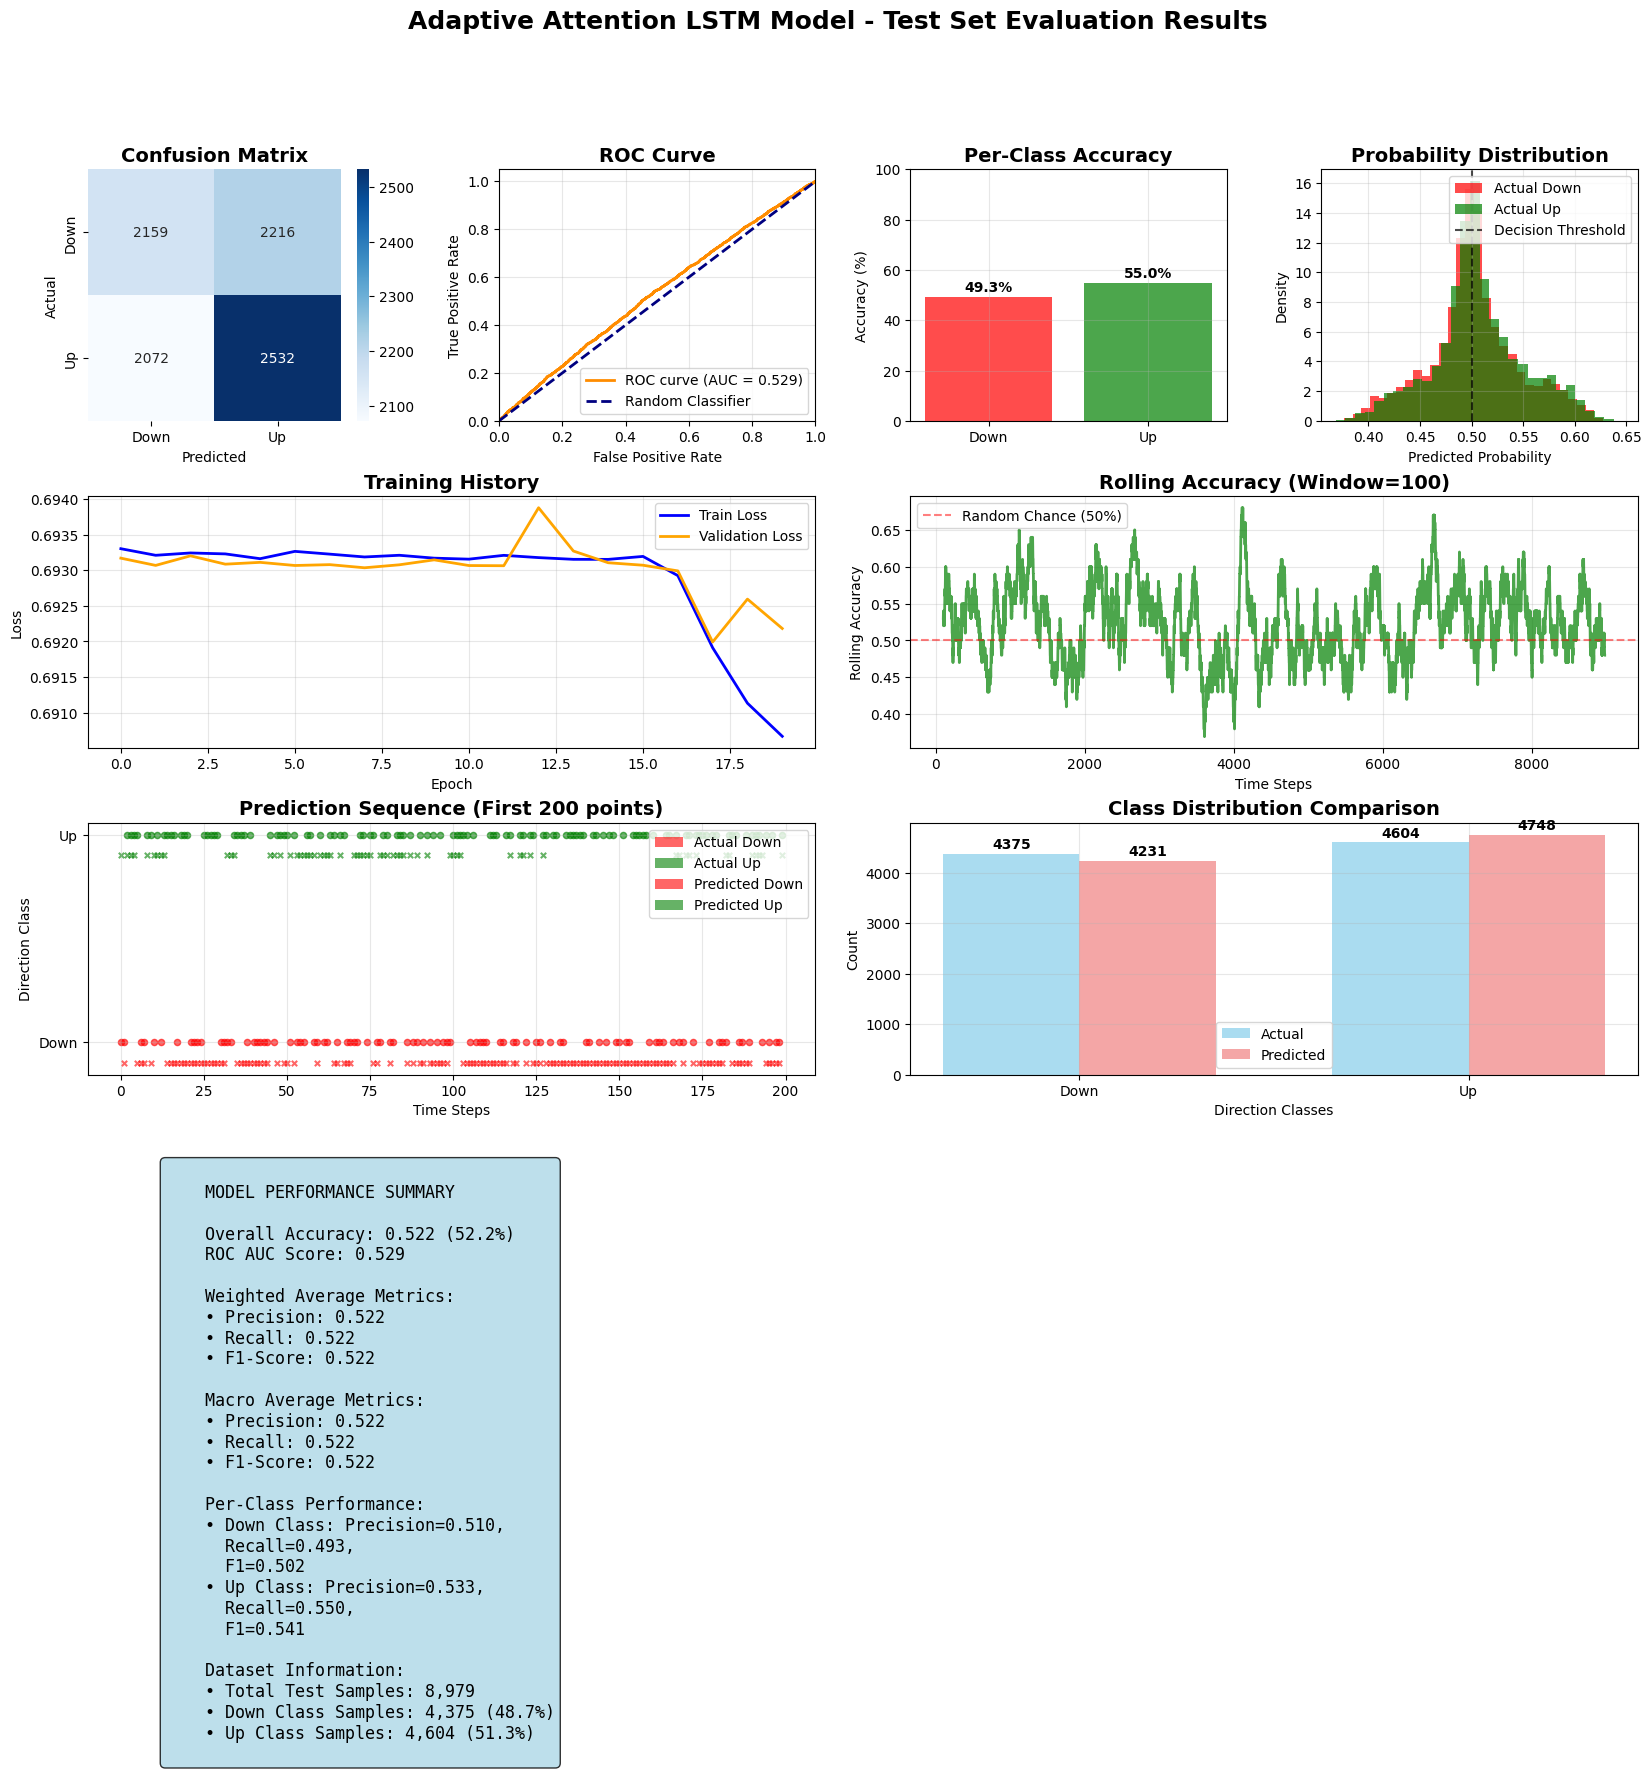


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Down       0.51      0.49      0.50      4375
          Up       0.53      0.55      0.54      4604

    accuracy                           0.52      8979
   macro avg       0.52      0.52      0.52      8979
weighted avg       0.52      0.52      0.52      8979


Final Test Set Performance:
Accuracy: 0.522 (52.2%)
ROC AUC: 0.529
F1-Score (Weighted): 0.522
F1-Score (Macro): 0.522


In [57]:
# Test Set Evaluation and Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

def evaluate_model_on_test_set(model, test_loader, criterion):
    """
    Comprehensive evaluation of the model on the test set with detailed visualizations.
    """
    model.eval()
    
    all_predictions = []
    all_actuals = []
    all_probabilities = []
    test_losses = []
    
    print("Evaluating model on test set...")
    
    with torch.no_grad():
        for batch_idx, (batch_X, batch_y, batch_hour, batch_weekday) in enumerate(test_loader):
            # Forward pass
            outputs = model(batch_X, batch_hour, batch_weekday)
            
            # Calculate loss
            batch_y_float = batch_y.float()
            loss = criterion(outputs.squeeze(), batch_y_float)
            test_losses.append(loss.item())
            
            # Get probabilities and predictions
            probabilities = torch.sigmoid(outputs.squeeze())
            predictions = (probabilities > 0.5).long()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_actuals.extend(batch_y.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            if batch_idx % 50 == 0:
                print(f"Processed batch {batch_idx}/{len(test_loader)}")
    
    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)
    all_probabilities = np.array(all_probabilities)
    
    # Calculate metrics
    test_accuracy = np.mean(all_actuals == all_predictions) * 100
    avg_test_loss = np.mean(test_losses)
    
    print(f"\nTest Set Results:")
    print(f"Average Loss: {avg_test_loss:.6f}")
    print(f"Accuracy: {test_accuracy:.2f}%")
    
    return all_predictions, all_actuals, all_probabilities, avg_test_loss

def create_comprehensive_visualization(predictions, actuals, probabilities, train_losses=None, val_losses=None):
    """
    Create comprehensive visualization of model performance.
    """
    fig = plt.figure(figsize=(20, 16))
    
    # Create a grid layout
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(actuals, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Down', 'Up'], 
                yticklabels=['Down', 'Up'],
                ax=ax1)
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(actuals, probabilities)
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    # 3. Prediction Distribution
    ax3 = fig.add_subplot(gs[0, 2])
    correct_predictions = (actuals == predictions)
    correct_by_class = [correct_predictions[actuals == i].mean() * 100 for i in range(2)]
    
    bars = ax3.bar(['Down', 'Up'], correct_by_class, color=['red', 'green'], alpha=0.7)
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    ax3.set_ylim(0, 100)
    ax3.grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for bar, acc in zip(bars, correct_by_class):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 4. Probability Distribution
    ax4 = fig.add_subplot(gs[0, 3])
    ax4.hist(probabilities[actuals == 0], bins=30, alpha=0.7, label='Actual Down', color='red', density=True)
    ax4.hist(probabilities[actuals == 1], bins=30, alpha=0.7, label='Actual Up', color='green', density=True)
    ax4.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold')
    ax4.set_xlabel('Predicted Probability')
    ax4.set_ylabel('Density')
    ax4.set_title('Probability Distribution', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Training History (if available)
    if train_losses is not None and val_losses is not None:
        ax5 = fig.add_subplot(gs[1, :2])
        ax5.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
        ax5.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
        ax5.set_title('Training History', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Epoch')
        ax5.set_ylabel('Loss')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    else:
        ax5 = fig.add_subplot(gs[1, :2])
        ax5.text(0.5, 0.5, 'Training History Not Available', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=16)
        ax5.set_title('Training History', fontsize=14, fontweight='bold')
    
    # 6. Rolling Accuracy
    ax6 = fig.add_subplot(gs[1, 2:])
    window_size = min(100, len(predictions) // 10)
    rolling_accuracy = []
    
    for i in range(window_size, len(predictions)):
        window_acc = np.mean(actuals[i-window_size:i] == predictions[i-window_size:i])
        rolling_accuracy.append(window_acc)
    
    ax6.plot(range(window_size, len(predictions)), rolling_accuracy, color='green', alpha=0.7, linewidth=2)
    ax6.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Chance (50%)')
    ax6.set_xlabel('Time Steps')
    ax6.set_ylabel('Rolling Accuracy')
    ax6.set_title(f'Rolling Accuracy (Window={window_size})', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Prediction Sequence (first 200 points)
    ax7 = fig.add_subplot(gs[2, :2])
    n_seq = min(200, len(predictions))
    colors = ['red', 'green']
    
    for i in range(n_seq):
        ax7.scatter(i, actuals[i], color=colors[actuals[i]], alpha=0.6, s=20, marker='o')
        ax7.scatter(i, predictions[i] - 0.1, color=colors[predictions[i]], alpha=0.6, s=15, marker='x')
    
    ax7.set_xlabel('Time Steps')
    ax7.set_ylabel('Direction Class')
    ax7.set_title(f'Prediction Sequence (First {n_seq} points)', fontsize=14, fontweight='bold')
    ax7.set_yticks([0, 1])
    ax7.set_yticklabels(['Down', 'Up'])
    ax7.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.6, label='Actual Down'),
                      Patch(facecolor='green', alpha=0.6, label='Actual Up'),
                      Patch(facecolor='red', alpha=0.6, label='Predicted Down', linestyle='--'),
                      Patch(facecolor='green', alpha=0.6, label='Predicted Up', linestyle='--')]
    ax7.legend(handles=legend_elements, loc='upper right')
    
    # 8. Class Distribution
    ax8 = fig.add_subplot(gs[2, 2:])
    actual_counts = np.bincount(actuals, minlength=2)
    pred_counts = np.bincount(predictions, minlength=2)
    
    x = np.arange(2)
    width = 0.35
    
    bars1 = ax8.bar(x - width/2, actual_counts, width, label='Actual', alpha=0.7, color='skyblue')
    bars2 = ax8.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.7, color='lightcoral')
    
    ax8.set_xlabel('Direction Classes')
    ax8.set_ylabel('Count')
    ax8.set_title('Class Distribution Comparison', fontsize=14, fontweight='bold')
    ax8.set_xticks(x)
    ax8.set_xticklabels(['Down', 'Up'])
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax8.text(bar.get_x() + bar.get_width()/2, height + max(actual_counts.max(), pred_counts.max()) * 0.01,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 9. Performance Metrics Summary
    ax9 = fig.add_subplot(gs[3, :])
    ax9.axis('off')
    
    # Calculate detailed metrics
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    
    precision, recall, f1, support = precision_recall_fscore_support(actuals, predictions, average='weighted')
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(actuals, predictions, average='macro')
    
    # Create metrics text
    metrics_text = f"""
    MODEL PERFORMANCE SUMMARY
    
    Overall Accuracy: {accuracy_score(actuals, predictions):.3f} ({accuracy_score(actuals, predictions)*100:.1f}%)
    ROC AUC Score: {roc_auc:.3f}
    
    Weighted Average Metrics:
    • Precision: {precision:.3f}
    • Recall: {recall:.3f}
    • F1-Score: {f1:.3f}
    
    Macro Average Metrics:
    • Precision: {precision_macro:.3f}
    • Recall: {recall_macro:.3f}
    • F1-Score: {f1_macro:.3f}
    
    Per-Class Performance:
    • Down Class: Precision={precision_recall_fscore_support(actuals, predictions)[0][0]:.3f}, 
      Recall={precision_recall_fscore_support(actuals, predictions)[1][0]:.3f}, 
      F1={precision_recall_fscore_support(actuals, predictions)[2][0]:.3f}
    • Up Class: Precision={precision_recall_fscore_support(actuals, predictions)[0][1]:.3f}, 
      Recall={precision_recall_fscore_support(actuals, predictions)[1][1]:.3f}, 
      F1={precision_recall_fscore_support(actuals, predictions)[2][1]:.3f}
    
    Dataset Information:
    • Total Test Samples: {len(actuals):,}
    • Down Class Samples: {actual_counts[0]:,} ({actual_counts[0]/len(actuals)*100:.1f}%)
    • Up Class Samples: {actual_counts[1]:,} ({actual_counts[1]/len(actuals)*100:.1f}%)
    """
    
    ax9.text(0.05, 0.95, metrics_text, transform=ax9.transAxes, 
             verticalalignment='top', fontfamily='monospace', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('Adaptive Attention LSTM Model - Test Set Evaluation Results', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification report
    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*80)
    print(classification_report(actuals, predictions, target_names=['Down', 'Up']))
    
    return {
        'accuracy': accuracy_score(actuals, predictions),
        'roc_auc': roc_auc,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }

# Run the evaluation
print("Starting comprehensive test set evaluation...")

# Evaluate the model
test_predictions, test_actuals, test_probabilities, avg_test_loss = evaluate_model_on_test_set(
    adaptive_model, test_loader, criterion
)

# Create comprehensive visualization
metrics = create_comprehensive_visualization(
    test_predictions, test_actuals, test_probabilities, 
    train_losses, val_losses
)

print(f"\nFinal Test Set Performance:")
print(f"Accuracy: {metrics['accuracy']:.3f} ({metrics['accuracy']*100:.1f}%)")
print(f"ROC AUC: {metrics['roc_auc']:.3f}")
print(f"F1-Score (Weighted): {metrics['f1_weighted']:.3f}")
print(f"F1-Score (Macro): {metrics['f1_macro']:.3f}")

C:\Users\aliya\AppData\Local\Temp\ipykernel_17224\582997166.py:125: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(box_data, labels=box_labels)
C:\Users\aliya\AppData\Local\Temp\ipykernel_17224\582997166.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(box_data_decay, labels=box_labels_decay)


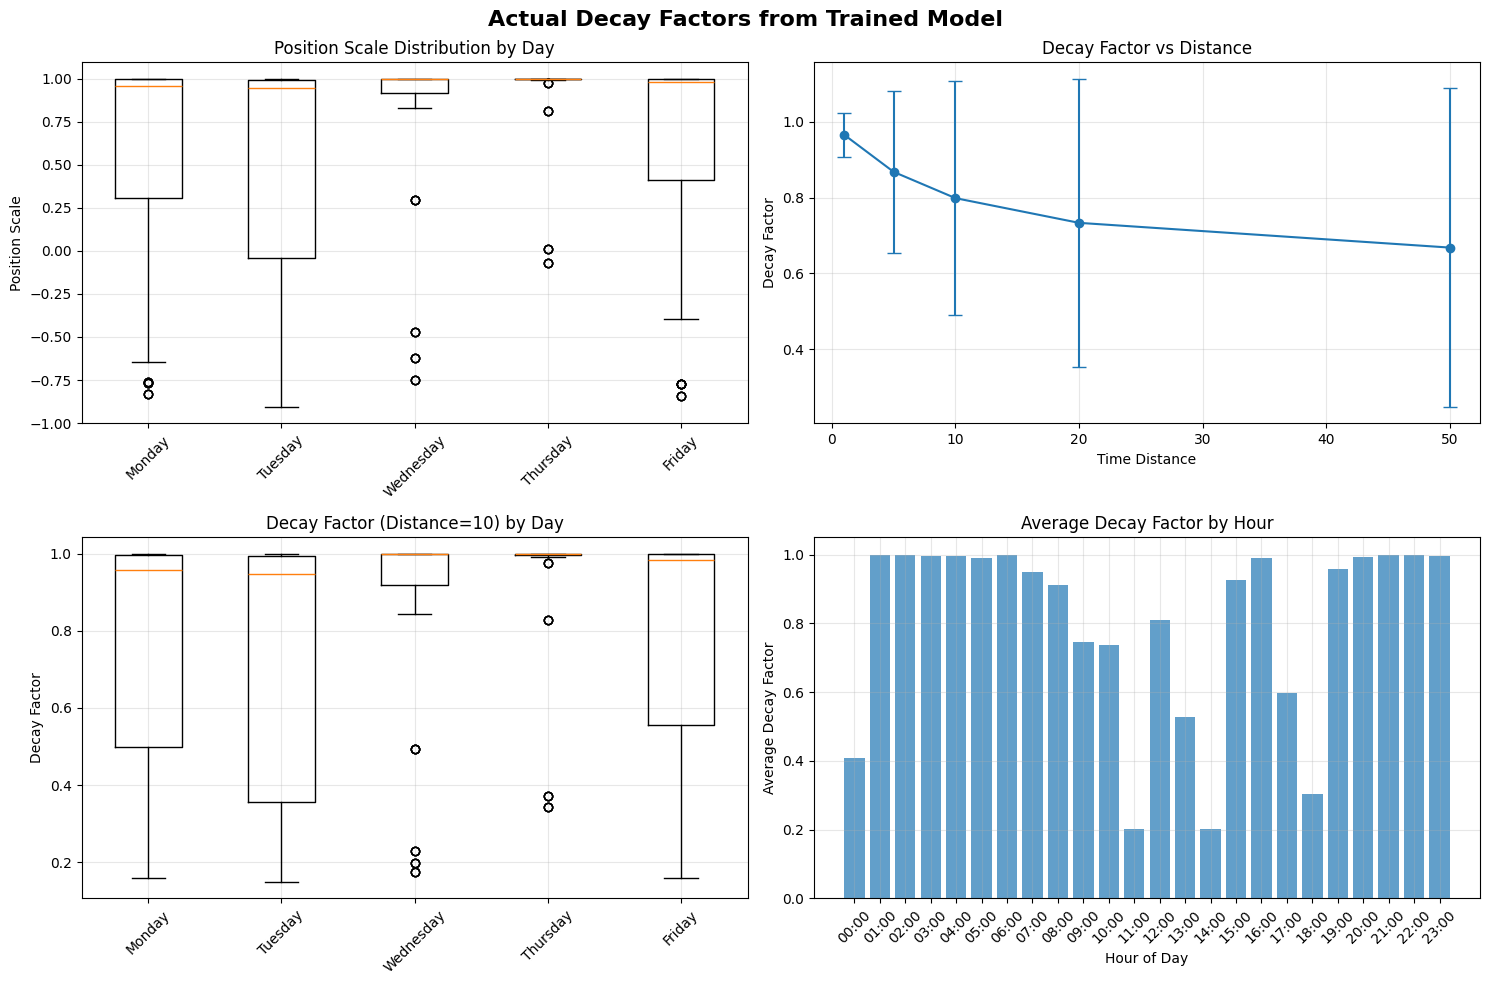

ACTUAL DECAY FACTOR ANALYSIS FROM TRAINED MODEL

Sample size: 500
Position scale - Mean: 0.6328, Std: 0.6278

Decay factors by distance:
  Distance  1: Mean=0.9658, Std=0.0578
  Distance  5: Mean=0.8678, Std=0.2131
  Distance 10: Mean=0.7985, Std=0.3092
  Distance 20: Mean=0.7333, Std=0.3805
  Distance 50: Mean=0.6680, Std=0.4211

Decay factors by day (distance=10):
      Monday: Mean=0.7380, Std=0.3234, Count=101
     Tuesday: Mean=0.7016, Std=0.3502, Count=120
   Wednesday: Mean=0.8629, Std=0.2708, Count=99
    Thursday: Mean=0.9375, Std=0.1783, Count=96
      Friday: Mean=0.7753, Std=0.3166, Count=84


In [54]:
def extract_decay_factors_from_trained_model(model, sample_data, sample_hours, sample_weekdays):
    """
    Extract actual decay factors from the trained adaptive attention model.
    
    Args:
        model: Your trained AdaptiveAttentionLSTMModel
        sample_data: Sample input sequences (batch_size, seq_len, features)
        sample_hours: Sample hour values (batch_size,)
        sample_weekdays: Sample weekday values (batch_size,)
    """
    
    # Create a modified version of the attention mechanism that returns intermediate values
    class DecayExtractor:
        def __init__(self, attention_module):
            self.attention = attention_module
            
        def extract_decay_factors(self, query, key, value, hour, weekday):
            """Extract decay factors from the attention mechanism."""
            batch_size, seq_len = query.shape[0], query.shape[1]
            
            # Get temporal conditioning (same as in original)
            hour_emb = self.attention.hour_embedding(hour)
            weekday_emb = self.attention.weekday_embedding(weekday)
            temporal_condition = torch.cat([hour_emb, weekday_emb], dim=-1)
            
            # Get position scale (same as in original)
            position_scale = self.attention.position_modulator(temporal_condition)
            
            # Calculate position distances
            positions = torch.arange(seq_len, device=query.device).float()
            position_matrix = positions.unsqueeze(0) - positions.unsqueeze(1)
            position_distances = torch.abs(position_matrix)
            
            # Calculate decay factors for different distances
            decay_factors = {}
            for distance in [1, 5, 10, 20, 50]:
                decay_factor = torch.exp(-0.1 * distance * (1 - position_scale.view(batch_size, 1, 1, 1)))
                decay_factors[f'distance_{distance}'] = decay_factor.squeeze().cpu().numpy()
            
            return {
                'position_scale': position_scale.squeeze().cpu().numpy(),
                'temporal_condition': temporal_condition.squeeze().cpu().numpy(),
                'decay_factors': decay_factors
            }
    
    # Extract the attention module from your model
    attention_module = model.adaptive_attention
    extractor = DecayExtractor(attention_module)
    
    # Get LSTM outputs (we need to run the model up to the attention layer)
    model.eval()
    with torch.no_grad():
        # Run through bottleneck and LSTM
        x = model.bottleneck(sample_data)
        x = model.bottleneck_activation(x)
        x = model.bottleneck_dropout(x)
        
        h0 = torch.zeros(model.num_layers * 2, x.size(0), model.lstm_units).to(x.device)
        c0 = torch.zeros(model.num_layers * 2, x.size(0), model.lstm_units).to(x.device)
        
        lstm_out, (hn, cn) = model.lstm(x, (h0, c0))
        
        # Extract decay factors
        results = extractor.extract_decay_factors(
            query=lstm_out,
            key=lstm_out, 
            value=lstm_out,
            hour=sample_hours,
            weekday=sample_weekdays
        )
    
    return results

def visualize_actual_decay_factors(model, test_loader, num_samples=100):
    """
    Visualize decay factors from the actual trained model using real data.
    """
    
    # Get sample data from test loader
    model.eval()
    sample_data = []
    sample_hours = []
    sample_weekdays = []
    
    with torch.no_grad():
        for i, (batch_X, batch_y, batch_hour, batch_weekday) in enumerate(test_loader):
            if i * batch_X.size(0) >= num_samples:
                break
                
            sample_data.append(batch_X)
            sample_hours.append(batch_hour)
            sample_weekdays.append(batch_weekday)
    
    # Concatenate samples
    sample_data = torch.cat(sample_data, dim=0)[:num_samples]
    sample_hours = torch.cat(sample_hours, dim=0)[:num_samples]
    sample_weekdays = torch.cat(sample_weekdays, dim=0)[:num_samples]
    
    # Extract decay factors
    results = extract_decay_factors_from_trained_model(
        model, sample_data, sample_hours, sample_weekdays
    )
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Actual Decay Factors from Trained Model', fontsize=16, fontweight='bold')
    
    # 1. Position Scale by Day
    ax1 = axes[0, 0]
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    position_scales_by_day = []
    for day in range(7):
        day_mask = sample_weekdays.cpu().numpy() == day
        if np.any(day_mask):
            day_scales = results['position_scale'][day_mask]
            position_scales_by_day.append(day_scales)
        else:
            position_scales_by_day.append(np.array([]))
    
    # Box plot of position scales by day
    box_data = [scales for scales in position_scales_by_day if len(scales) > 0]
    box_labels = [days[i] for i in range(7) if len(position_scales_by_day[i]) > 0]
    
    ax1.boxplot(box_data, labels=box_labels)
    ax1.set_title('Position Scale Distribution by Day')
    ax1.set_ylabel('Position Scale')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Decay Factors by Distance
    ax2 = axes[0, 1]
    distances = [1, 5, 10, 20, 50]
    decay_means = []
    decay_stds = []
    
    for dist in distances:
        decay_values = results['decay_factors'][f'distance_{dist}']
        decay_means.append(np.mean(decay_values))
        decay_stds.append(np.std(decay_values))
    
    ax2.errorbar(distances, decay_means, yerr=decay_stds, marker='o', capsize=5)
    ax2.set_title('Decay Factor vs Distance')
    ax2.set_xlabel('Time Distance')
    ax2.set_ylabel('Decay Factor')
    ax2.grid(True, alpha=0.3)
    
    # 3. Decay Factor by Day (for distance=10)
    ax3 = axes[1, 0]
    decay_by_day = []
    for day in range(7):
        day_mask = sample_weekdays.cpu().numpy() == day
        if np.any(day_mask):
            day_decay = results['decay_factors']['distance_10'][day_mask]
            decay_by_day.append(day_decay)
        else:
            decay_by_day.append(np.array([]))
    
    box_data_decay = [decay for decay in decay_by_day if len(decay) > 0]
    box_labels_decay = [days[i] for i in range(7) if len(decay_by_day[i]) > 0]
    
    ax3.boxplot(box_data_decay, labels=box_labels_decay)
    ax3.set_title('Decay Factor (Distance=10) by Day')
    ax3.set_ylabel('Decay Factor')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # 4. Hour vs Decay Factor
    ax4 = axes[1, 1]
    hours = sample_hours.cpu().numpy()
    decay_10 = results['decay_factors']['distance_10']
    
    # Group by hour and calculate mean decay
    hour_decay_means = []
    hour_labels = []
    for hour in range(24):
        hour_mask = hours == hour
        if np.any(hour_mask):
            hour_decay_means.append(np.mean(decay_10[hour_mask]))
            hour_labels.append(f'{hour:02d}:00')
    
    ax4.bar(range(len(hour_decay_means)), hour_decay_means, alpha=0.7)
    ax4.set_title('Average Decay Factor by Hour')
    ax4.set_xlabel('Hour of Day')
    ax4.set_ylabel('Average Decay Factor')
    ax4.set_xticks(range(len(hour_labels)))
    ax4.set_xticklabels(hour_labels, rotation=45)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("=" * 80)
    print("ACTUAL DECAY FACTOR ANALYSIS FROM TRAINED MODEL")
    print("=" * 80)
    
    print(f"\nSample size: {num_samples}")
    print(f"Position scale - Mean: {np.mean(results['position_scale']):.4f}, "
          f"Std: {np.std(results['position_scale']):.4f}")
    
    print("\nDecay factors by distance:")
    for dist in distances:
        decay_vals = results['decay_factors'][f'distance_{dist}']
        print(f"  Distance {dist:2d}: Mean={np.mean(decay_vals):.4f}, "
              f"Std={np.std(decay_vals):.4f}")
    
    print("\nDecay factors by day (distance=10):")
    for i, day in enumerate(days):
        day_mask = sample_weekdays.cpu().numpy() == i
        if np.any(day_mask):
            day_decay = results['decay_factors']['distance_10'][day_mask]
            print(f"  {day:>10}: Mean={np.mean(day_decay):.4f}, "
                  f"Std={np.std(day_decay):.4f}, Count={len(day_decay)}")
    
    return results

# Usage: Run this with your trained model
results = visualize_actual_decay_factors(adaptive_model, test_loader, num_samples=500)